<a href="https://colab.research.google.com/github/cusiandrea/datascienceportfolio/blob/main/Sentiment_HF_Italian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Italian sentiment analysis model fine tuning

In this notebook a pre-trained LLM is fine-tuned in order to classify sentiment in Italian language tweets, using Hugging Face libraries.

##Set up

In [12]:
!pip install -U "transformers>=4.44" "datasets>=2.20" "accelerate>=0.33" evaluate scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 133.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 15.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
  Attempting uninst

In [1]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


In [2]:
from huggingface_hub import notebook_login
notebook_login()

##Configuration

The main parameters are conveniently defined as follows.
In particular, the model selected is twitter-XLM-roBERTa-base for sentiment analysis, a multilingual model, and the Italian language subset of mteb/tweet_sentiment_multilingual dataset is chosen for training and testing.

In [21]:
#model and dataset
MODEL_NAME = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
DATASET_NAME = "mteb/tweet_sentiment_multilingual"
DATASET_CONFIG = "italian"

#training parameters
NUM_EPOCHS = 5
LR = 2e-5
WEIGHT_DECAY = 0.01
TRAIN_BS = 16
EVAL_BS = 16
WARMUP_RATIO = 0.1
USE_FP16 = torch.cuda.is_available()

#seed
SEED = 42
from transformers import set_seed
set_seed(SEED)

##Dataset loading and EDA

In [22]:
from datasets import load_dataset

dataset = load_dataset(DATASET_NAME, DATASET_CONFIG)
dataset


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'lang'],
        num_rows: 1839
    })
    test: Dataset({
        features: ['text', 'label', 'lang'],
        num_rows: 870
    })
    validation: Dataset({
        features: ['text', 'label', 'lang'],
        num_rows: 324
    })
})

In [23]:
import pandas as pd

train_df = pd.DataFrame(dataset["train"])
val_df   = pd.DataFrame(dataset["validation"])
test_df  = pd.DataFrame(dataset["test"])

train_df.head()


,text,label,lang
0,@user mi fa sbagliare tutte le paroleeeee.,0,italian
1,@user perfetto hai visto poi alla fine anche o...,1,italian
2,"Rutelli: appoggio al governo #monti, sta lavor...",2,italian
3,RT @user: Non legalizzano la #cannabis Ma iper...,0,italian
4,"@user @user @user c'è da vergognarsi, ha fatto...",1,italian


Label names: ['negative', 'neutral', 'positive']


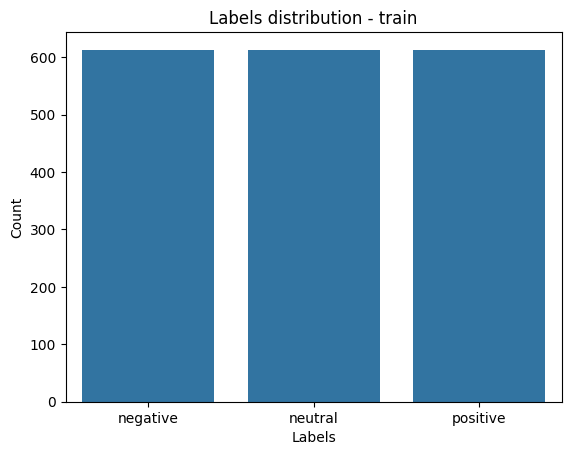

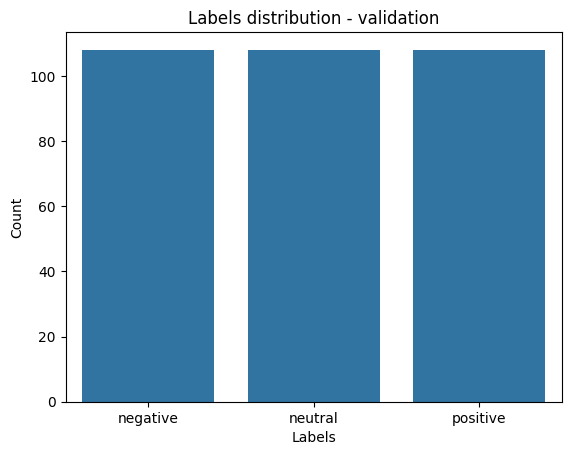

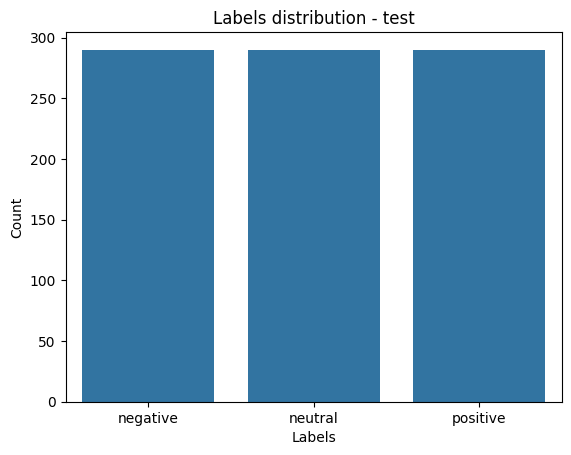

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

label_names = ["negative", "neutral", "positive"]
print("Label names:", label_names)

def plot_label_distribution(df, split_name):
    df_labels_as_int = df["label"].astype(int)
    counts = df_labels_as_int.value_counts().sort_index()
    labels = [label_names[i] for i in counts.index]
    plt.figure()
    sns.barplot(x=labels, y=counts.values)
    plt.title(f"Labels distribution - {split_name}")
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.show()

plot_label_distribution(train_df, "train")
plot_label_distribution(val_df, "validation")
plot_label_distribution(test_df, "test")

The dataset is quite small, but the three labels (negative, neutral, positive) are well balanced.

##Preprocessing data

In order to be correctly processed, the dataset needs to be prepared for the training. In particular, tweets are tokenized, truncated (if necessary) and padded.

In [25]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def preprocess(batch):
    tokenized_batch = tokenizer(batch["text"], truncation=True)
    tokenized_batch["label"] = [int(label) for label in batch["label"]] # Convert string labels to integers
    return tokenized_batch

tokenized_dataset = dataset.map(preprocess, batched=True)
tokenized_dataset

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Map:   0%|          | 0/1839 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/870 [00:00<?, ? examples/s]

Map:   0%|          | 0/324 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'lang', 'input_ids', 'attention_mask'],
        num_rows: 1839
    })
    test: Dataset({
        features: ['text', 'label', 'lang', 'input_ids', 'attention_mask'],
        num_rows: 870
    })
    validation: Dataset({
        features: ['text', 'label', 'lang', 'input_ids', 'attention_mask'],
        num_rows: 324
    })
})

In [26]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [27]:
label2id = {name: i for i, name in enumerate(label_names)}
id2label = {i: name for name, i in label2id.items()}
label2id, id2label

({'negative': 0, 'neutral': 1, 'positive': 2},
 {0: 'negative', 1: 'neutral', 2: 'positive'})

##Model, metrics defintion and training

The model is defined as a Hugging Face Transformers *AutoModelForSequenceClassification* object

In [28]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_names),
    id2label=id2label,
    label2id=label2id
)

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

*compute_metrics* function will be used to evaluate the model's performance

In [29]:
import evaluate
import numpy as np

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_metric.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"],
    }

*Training arguments* and *Trainer* object are set up for subsequent model training.

In [30]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=LR,
    warmup_ratio=WARMUP_RATIO,
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=TRAIN_BS,
    per_device_eval_batch_size=EVAL_BS,
    weight_decay=WEIGHT_DECAY,
    logging_steps=50,
    fp16=USE_FP16,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


/tmp/ipython-input-2588165485.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [31]:
train_result = trainer.train()
train_result

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.575500,0.733354,0.712963,0.711907
2,0.365500,0.949137,0.725309,0.721678
3,0.258000,1.166474,0.703704,0.700914
4,0.174100,1.314819,0.728395,0.728157
5,0.120300,1.412579,0.719136,0.718780


TrainOutput(global_step=575, training_loss=0.2773629217562468, metrics={'train_runtime': 375.9892, 'train_samples_per_second': 24.455, 'train_steps_per_second': 1.529, 'total_flos': 206136001561644.0, 'train_loss': 0.2773629217562468, 'epoch': 5.0})

##Model evaluation

In [32]:
test_metrics = trainer.evaluate(tokenized_dataset["test"])
test_metrics

{'eval_loss': 1.444072961807251,
 'eval_accuracy': 0.6850574712643678,
 'eval_f1_macro': 0.6833784073337285,
 'eval_runtime': 1.1809,
 'eval_samples_per_second': 736.741,
 'eval_steps_per_second': 46.576,
 'epoch': 5.0}

After 5 epochs of training the accuracy on the evaluation set is around 72%.
The performance on the test set is quite similar, around 69%.

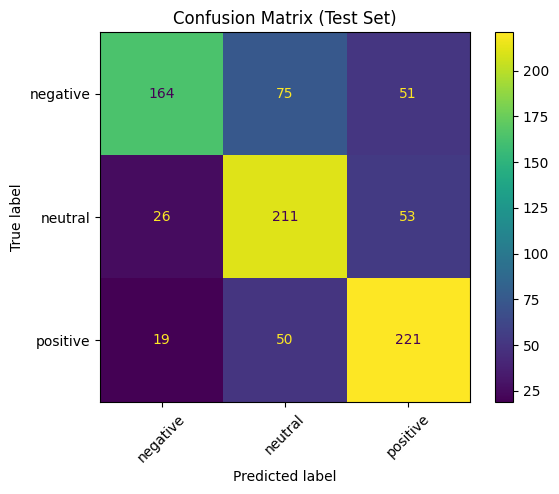

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds_output = trainer.predict(tokenized_dataset["test"])
y_true = preds_output.label_ids
y_pred = preds_output.predictions.argmax(axis=-1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix (Test Set)")
plt.show()


The confusion matrix shows a good general performance, considering the dataset size, with slightly worse accuracy in classifying negative tweets compared to neutral and positive.